## 1. Установка зависимостей

Установим необходимые библиотеки для работы платформы

In [ ]:
!pip install langgraph langchain-openai python-dotenv twilio tavily-python youtube-transcript-api google-api-python-client graphviz

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Импорты и конфигурация

Импортируем необходимые библиотеки и настроим конфигурацию

In [23]:
import os
from typing import Dict, Any, List, TypeVar
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.chains import LLMChain
from langchain.memory import ConversationBufferMemory
from langgraph.graph import StateGraph, END
from typing import TypedDict
from tavily import TavilyClient
import nest_asyncio
from googleapiclient.discovery import build
import graphviz
from IPython.display import SVG, display
from youtube_transcript_api import YouTubeTranscriptApi


# Настройка логирования
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from dotenv import load_dotenv
load_dotenv('/content/drive/MyDrive/1.env')

import os
openai_api_key = os.getenv('openai_api_key')
tavily_api_key = os.getenv('tavily_api_key')
youtube_api_key = os.getenv('youtube_api_key')

## 3. Реализация базового агента

Определяем базовый класс для всех агентов с использованием LangChain

In [24]:
class BaseAgent:
    def __init__(self, llm=None, tools=None):

        self.llm = llm or ChatOpenAI(
            model="gpt-4o",
            temperature=0.7,
            api_key=os.getenv("openai_api_key")
        )
        self.tools = tools or []
        self.memory = ConversationBufferMemory(return_messages=True)
        self.str_parser = StrOutputParser()
        self.json_parser = JsonOutputParser()
        self.logger = logging.getLogger(self.__class__.__name__)

    async def handle(self, state: Dict[str, Any]) -> Dict[str, Any]:
        try:
            self._validate_state(state)
            self.logger.info(f"Processing state in {self.__class__.__name__}")
            result = await self._handle_implementation(state)
            self.logger.info(f"Successfully processed state in {self.__class__.__name__}")
            return result
        except Exception as e:
            self.logger.error(f"Error in {self.__class__.__name__}: {str(e)}")
            raise

    async def _handle_implementation(self, state: Dict[str, Any]) -> Dict[str, Any]:
        raise NotImplementedError

    async def create_chain(self,
                          template: str,
                          output_key: str = "text",
                          memory: bool = False,
                          output_parser = None) -> LLMChain:
        try:
            prompt = ChatPromptTemplate.from_template(template)
            chain_config = {
                "llm": self.llm,
                "prompt": prompt,
                "output_key": output_key,
                "output_parser": output_parser or self.str_parser,
                "verbose": True
            }
            if memory:
                chain_config["memory"] = self.memory
            return LLMChain(**chain_config)
        except Exception as e:
            self.logger.error(f"Error creating chain: {e}")
            raise

    def _validate_state(self, state: Dict[str, Any]) -> None:
        required_fields = [
            "topics", "selected_topic", "clinical_case_text",
            "articles", "selected_article", "videos", "selected_video",
            "video_transcript", "case_questions", "article_questions",
            "video_questions", "discussion_questions", "glossary",
            "useful_phrases", "progress"
        ]
        missing = [f for f in required_fields if f not in state]
        if missing:
            raise ValueError(f"Missing required state fields: {', '.join(missing)}")

### 3.2 Агент для работы с темами

In [25]:
class TopicAgent(BaseAgent):
    async def _handle_implementation(self, state: Dict[str, Any]) -> Dict[str, Any]:
        topics = await self._generate_topics()

        print("\nAvailable topics:")
        for i, topic in enumerate(topics, 1):
            print(f"{i}. {topic}")

        while True:
            choice = input("\nSelect a topic number or type your own topic: ")
            if choice.isdigit() and 1 <= int(choice) <= len(topics):
                selected_topic = topics[int(choice)-1]
                break
            elif choice.strip():
                selected_topic = choice.strip()
                break
            print("Invalid selection. Please try again.")

        return {**state, "topics": topics, "selected_topic": selected_topic}

    async def _generate_topics(self) -> List[str]:
        template = (
            "You are an AI specialized in creating topics for a medical English conversational club. "
            "Generate 10 unique, engaging medical topics for discussion.\n"
            "Each topic should:\n"
            "1. Be relevant to current medical practice\n"
            "2. Encourage critical thinking\n"
            "3. Be suitable for medical English practice\n"
            f"4. avoiding these used topics: {', '.join(used_topics)}"
            "Format: Return only the topic titles, one per line, without number."
        )
        chain = await self.create_chain(template)
        response = await chain.arun({})
        return [t.strip() for t in response.split("\n") if t.strip()]

### 3.3 Агент для генерации клинических случаев

In [26]:
class ClinicalCaseAgent(BaseAgent):
    async def _handle_implementation(self, state: Dict[str, Any]) -> Dict[str, Any]:
        topic = state.get("selected_topic")
        if not topic:
            raise ValueError("Тема не выбрана")

        clinical_case = await self._generate_case(topic)
        return {**state, "clinical_case_text": clinical_case}

    async def _generate_case(self, topic: str) -> str:
        template = (
            f"Create a detailed clinical case in English for the topic: '{topic}'.\n"
            f"Include:\n"
            f"1. Patient History\n"
            f"2. Presenting Symptoms\n"
            f"3. Physical Examination Findings\n"
            f"4. Laboratory/Imaging Results\n"
            f"5. Diagnosis\n"
            f"6. Treatment Plan\n\n"
            f"Make the case realistic, educational, and suitable for medical English practice."
        )
        chain = await self.create_chain(template)
        return await chain.arun({})

### 3.4 Агент для поиска статей

In [27]:
class ArticleAgent(BaseAgent):
    def __init__(self):
        super().__init__()
        self.tavily = TavilyClient(api_key=os.getenv("tavily_api_key"))

    async def _handle_implementation(self, state: Dict[str, Any]) -> Dict[str, Any]:
        topic = state.get("selected_topic")
        if not topic:
            raise ValueError("Тема не выбрана")

        articles = await self._find_articles(topic)

        print("\nAvailable articles:")
        for i, article in enumerate(articles, 1):
            print(f"{i}. {article['title']}")
            print(f"   URL: {article['url']}")

        while True:
            choice = input("Select an article number or press Enter to use default: ")
            if not choice.strip():
                selected_article = articles[0] if articles else {
                    "title": "Sample Article",
                    "url": "https://example.com"
                }
                break
            elif choice.isdigit() and 1 <= int(choice) <= len(articles):
                selected_article = articles[int(choice)-1]
                break
            print("Invalid selection. Please try again.")

        print("\nPlease paste the article content (press Enter twice when done):")
        content_lines = []
        while True:
            line = input()
            if line.strip() == "":
                break
            content_lines.append(line)
        selected_article["content"] = "\n".join(content_lines)

        return {**state, "articles": articles, "selected_article": selected_article}

    async def _find_articles(self, topic: str) -> List[Dict[str, str]]:
        search_results = self.tavily.search(topic, search_depth="advanced")
        return [
            {"title": result.get("title", "No Title"), "url": result.get("url", "No URL")}
            for result in search_results.get("results", [])[:5]
        ]

### 3.5 Агент для работы с видео

In [28]:
class VideoAgent(BaseAgent):
    def __init__(self):
        super().__init__()
        self.youtube = build("youtube", "v3", developerKey=os.getenv("youtube_api_key"))

    async def _handle_implementation(self, state: Dict[str, Any]) -> Dict[str, Any]:
        topic = state.get("selected_topic")
        if not topic:
            raise ValueError("Тема не выбрана")

        videos = await self._find_videos(topic)

        print("\nAvailable videos:")
        for i, video in enumerate(videos, 1):
            print(f"{i}. {video['title']}")
            print(f"   URL: {video['url']}")

        while True:
            choice = input("Select a video number or press Enter to use default: ")
            if not choice.strip():
                selected_video = videos[0] if videos else {
                    "title": "Sample Video",
                    "url": "https://www.youtube.com/watch?v=sample"
                }
                break
            elif choice.isdigit() and 1 <= int(choice) <= len(videos):
                selected_video = videos[int(choice)-1]
                break
            print("Invalid selection. Please try again.")

        try:
            transcript = await self._get_transcript(selected_video["url"])
        except Exception:
            transcript = await self._generate_sample_transcript(topic)

        return {
            **state,
            "videos": videos,
            "selected_video": selected_video,
            "video_transcript": transcript
        }

    async def _find_videos(self, topic: str) -> List[Dict[str, str]]:
        search_response = self.youtube.search().list(
            q=topic,
            part="snippet",
            maxResults=10,
            type="video",
            videoDuration="medium"
        ).execute()

        return [
            {
                "title": item["snippet"]["title"],
                "url": f"https://www.youtube.com/watch?v={item['id']['videoId']}"
            }
            for item in search_response.get("items", [])
        ]

    async def _get_transcript(self, video_url: str) -> str:
        video_id = video_url.split("v=")[1].split("&")[0]
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        return " ".join([item['text'] for item in transcript])

### 3.6 Агент для генерации вопросов

In [29]:
class QuestionAgent(BaseAgent):
    async def _handle_implementation(self, state: Dict[str, Any]) -> Dict[str, Any]:
        case_questions = await self._generate_case_questions(state.get("clinical_case_text", ""))
        article_questions = await self._generate_article_questions(
            state.get("selected_article", {}).get("content", "")
        )
        video_questions = await self._generate_video_questions(state.get("video_transcript", ""))
        discussion_questions = await self._generate_discussion_questions(
            state.get("selected_topic", "")
        )

        return {
            **state,
            "case_questions": case_questions,
            "article_questions": article_questions,
            "video_questions": video_questions,
            "discussion_questions": discussion_questions
        }

    async def _generate_case_questions(self, case: str) -> List[str]:
        template = (
            f"Based on this clinical case, generate 10 engaging discussion questions:\n\n{case}"
            f"The questions should not be numbered."
        )
        chain = await self.create_chain(template)
        response = await chain.arun({})
        return [q.strip() for q in response.split("\n") if q.strip()]

    async def _generate_article_questions(self, article: str) -> List[str]:
        template = (
            f"Based on this article, generate 10 discussion questions:\n\n{article}"
            f"The questions should not be numbered."
        )
        chain = await self.create_chain(template)
        response = await chain.arun({})
        return [q.strip() for q in response.split("\n") if q.strip()]

    async def _generate_video_questions(self, transcript: str) -> List[str]:
        template = (
            f"Based on this video transcript, generate 10 discussion questions:\n\n{transcript}"
            f"The questions should not be numbered."
        )
        chain = await self.create_chain(template)
        response = await chain.arun({})
        return [q.strip() for q in response.split("\n") if q.strip()]

    async def _generate_discussion_questions(self, topic: str) -> List[str]:
        template = (
            f"Generate 20 engaging discussion questions about {topic}. "
            f"Questions should be open-ended and encourage critical thinking."
            f"The questions should not be numbered."
        )
        chain = await self.create_chain(template)
        response = await chain.arun({})
        return [q.strip() for q in response.split("\n") if q.strip()]

### 3.7 Агент для создания глоссария

In [30]:
class GlossaryAgent(BaseAgent):
    async def _handle_implementation(self, state: Dict[str, Any]) -> Dict[str, Any]:
        topic = state.get("selected_topic", "")
        article = state.get("selected_article", {}).get("content", "")
        transcript = state.get("video_transcript", "")

        glossary = await self._generate_glossary(topic, article, transcript)

        return {**state, "glossary": glossary}

    async def _generate_glossary(self, topic: str, article: str, transcript: str) -> str:
        template = (
            f"Create a medical English glossary based on:\n"
            f"Topic: {topic}\n"
            f"Article: {article[:1000]}...\n"
            f"Video Transcript: {transcript[:1000]}...\n\n"
            f"Generate 30-40 key terms with Russian translations. "
            f"Avoid simple terms and those similar to Russian. "
            f"Format as '**[English term]**: [Russian translation]'"
        )
        chain = await self.create_chain(template)
        return await chain.arun({})

### 3.8 Агент для генерации полезных фраз

In [31]:
class PhraseAgent(BaseAgent):
    async def _handle_implementation(self, state: Dict[str, Any]) -> Dict[str, Any]:
        topic = state.get("selected_topic")
        if not topic:
            raise ValueError("Тема не выбрана")

        phrases = await self._generate_phrases(topic)

        return {**state, "useful_phrases": phrases}

    async def _generate_phrases(self, topic: str) -> List[str]:
        template = (
            f"Generate 20-30 useful English phrases for discussing {topic}. "
            f"Include phrases for expressing opinions, asking questions, "
            f"agreeing/disagreeing, and discussing medical topics. "
            f"Each phrase should be on a new line without number"

        )
        chain = await self.create_chain(template)
        response = await chain.arun({})
        return [p.strip() for p in response.split("\n") if p.strip()]

## 4. Создание рабочего процесса

Определим и запустим последовательный рабочий процесс с использованием всех агентов

In [32]:
def create_workflow() -> StateGraph:

    # Инициализация агентов
    agents = {
        "topic": TopicAgent(),
        "case": ClinicalCaseAgent(),
        "article": ArticleAgent(),
        "video": VideoAgent(),
        "question": QuestionAgent(),
        "glossary": GlossaryAgent(),
        "phrase": PhraseAgent()
    }

    class WorkflowState(TypedDict):
        topics: list[str]
        selected_topic: str
        clinical_case_text: str
        articles: list[dict]
        selected_article: dict
        videos: list[dict]
        selected_video: dict
        video_transcript: str
        case_questions: list[str]
        article_questions: list[str]
        video_questions: list[str]
        discussion_questions: list[str]
        glossary: str
        useful_phrases: list[str]
        progress: dict

    # Создание графа рабочего процесса с определенной схемой
    workflow = StateGraph(state_schema=WorkflowState)

    # Добавление узлов для каждого агента
    for name, agent in agents.items():
        workflow.add_node(f"generate_{name}", agent.handle)

    # Настройка последовательности выполнения
    workflow.set_entry_point("generate_topic")
    workflow.add_edge("generate_topic", "generate_case")
    workflow.add_edge("generate_case", "generate_article")
    workflow.add_edge("generate_article", "generate_video")
    workflow.add_edge("generate_video", "generate_question")
    workflow.add_edge("generate_question", "generate_glossary")
    workflow.add_edge("generate_glossary", "generate_phrase")
    workflow.add_edge("generate_phrase", END)

    return workflow.compile()

## 4. Визуализация рабочего процесса

Создадим наглядное представление последовательности работы агентов в виде графа

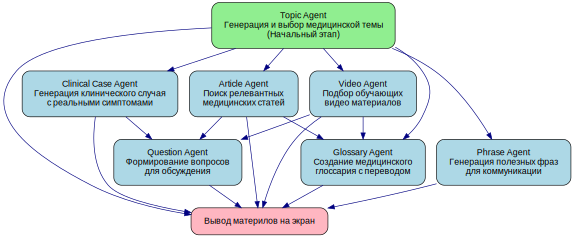

In [33]:

def create_workflow_graph():

    # Создаем новый ориентированный граф
    dot = graphviz.Digraph(comment='Medical English Speaking Club Workflow')
    dot.attr(rankdir='TB', size='8,8')

    # Определяем стиль
    dot.attr('node', shape='box',
             style='rounded,filled',
             fillcolor='lightblue',
             fontname='Arial',
             margin='0.3,0.2')

    dot.attr('edge', color='navy',
             fontcolor='darkgreen',
             fontsize='10',
             fontname='Arial')

    # Добавляем узлы для каждого агента с описанием
    nodes = [
        ('topic', 'Topic Agent\nГенерация и выбор медицинской темы\n(Начальный этап)'),
        ('case', 'Clinical Case Agent\nГенерация клинического случая\nс реальными симптомами'),
        ('article', 'Article Agent\nПоиск релевантных\nмедицинских статей'),
        ('video', 'Video Agent\nПодбор обучающих\nвидео материалов'),
        ('question', 'Question Agent\nФормирование вопросов\nдля обсуждения'),
        ('glossary', 'Glossary Agent\nСоздание медицинского\nглоссария с переводом'),
        ('phrase', 'Phrase Agent\nГенерация полезных фраз\nдля коммуникации'),
        ('print', 'Вывод материлов на экран')
    ]

    # Добавление узлов с пользовательскими стилями
    for id, label in nodes:
        if id == 'topic':
            dot.node(id, label, fillcolor='lightgreen')
        elif id == 'print':
            dot.node(id, label, fillcolor='lightpink')
        else:
            dot.node(id, label)

    # Добавляем ребра с описаниями
    edges = [
        ('topic', 'case'),
        ('topic', 'article'),
        ('topic', 'video'),
        ('case', 'question'),
        ('article', 'question'),
        ('video', 'question'),
        ('topic', 'glossary'),
        ('article', 'glossary'),
        ('video', 'glossary'),
        ('topic', 'phrase'),
        ('topic', 'print'),
        ('case', 'print'),
        ('article', 'print'),
        ('video', 'print'),
        ('glossary', 'print'),
        ('question', 'print'),
        ('phrase', 'print')
    ]

    for src, dst in edges:
        dot.edge(src, dst)

    # Укажем директорию для выгрузки схемы
    output_dir = 'static'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Сохраним схемы
    dot.render(f'{output_dir}/workflow_graph', format='svg', cleanup=True)

    # И выведем на экран
    display(SVG(f'{output_dir}/workflow_graph.svg'))

create_workflow_graph()

## 5. Запуск рабочего процесса

Определим перчень использованных тем

In [34]:
 used_topics = ['Should a drug dealer receive a heart transplant?', 'Surrogacy', 'Alternative medicine',
'Suicide',
'Robots and AI in medicine ',
'Cultural aspects in medicine',
'Clinical trials',
'Healthcare workers security',
'Crossover kidney transplantation',
'Euthanasia',
'COVID-19',
'Intersex',
'Limits for nurses and Healthcare workers',
'Brain enhancing drugs and nutritional supplements',
'Disabled girls future',
'Burnout',
'Back-alley plastic surgery',
'Questionable CS',
'Disability in medical workers',
'STIs',
'Cancer',
'Stress',
'Drug addiction',
'Health of Migrants and refugees',
'Domestic violence',
'HIV',
'Sport',
'New Year celebration health safety',
'Vacation for doctors',
'Animals and human health',
'Sleep and its effects on health',
'Job hunting in medicine',
'Diets and nutrition',
'Telemedicine',
'Global health and medical volunteering',
'Elderly health',
'Medical specialties',
'Summer and health',
'Pediatrics: Stages of child development and health in different stages',
'Medical blogs',
'Vaccination',
'Seasonal affective disorder',
'Flying and health',
'Menstrual health',
'Leukemia and bone marrow transplantation',
'Patient types',
'Homelessness, poverty and health',
'Innovations in medicine in 2023',
'Psychosomatic disorders',
'Working condition for doctors',
'Internet in medicine',
'Eating disorders',
'Skin care',
'Blood Lab tests',
'Instrumental diagnostic in medicine',
'Environment, pollution and health',
'Genetics',
'Pharmaceutical businesses and medicine',
'Overpopulation and health',
'Mpox',
'Medical errors',
'The Role of Personalized Medicine in Modern Healthcare'
]

Инициализируем и запустим весь процесс генерации материалов

In [38]:
nest_asyncio.apply()


async def run_workflow():
    try:
        print("Запуск генерации учебных материалов по медицинскому английскому")

        # Создание рабочего процесса
        workflow = create_workflow()

        # Инициализация начального состояния
        initial_state = {
            "topics": [],
            "selected_topic": "",
            "clinical_case_text": "",
            "articles": [],
            "selected_article": {},
            "videos": [],
            "selected_video": {},
            "video_transcript": "",
            "case_questions": [],
            "article_questions": [],
            "video_questions": [],
            "discussion_questions": [],
            "glossary": "",
            "useful_phrases": [],
            "progress": {
                "completed_topics":[],
                "viewed_cases": [],
                "read_articles": [],
                "watched_videos": [],
                "answered_questions": [],
                "completion_percentage": 0,
                "last_update": None,
                "learning_path": []
            }
        }

        # Запуск рабочего процесса
        final_state = await workflow.ainvoke(initial_state)

        print("\n=== РЕЗУЛЬТАТЫ ГЕНЕРАЦИИ ===")
        print(f"ТЕМА: {final_state['selected_topic']}")

        print("\nВОПРОСЫ К ТЕМЕ:")
        for i, q in enumerate(final_state['discussion_questions'], 1):
            print(f"{i}. {q}")

        print("\nКЛИНИЧЕСКИЙ СЛУЧАЙ:")
        print(final_state['clinical_case_text'])

        print("\nВОПРОСЫ К КЛИНИЧЕСКОМУ СЛУЧАЮ:")
        for i, q in enumerate(final_state['case_questions'], 1):
            print(f"{i}. {q}")

        print("\nСТАТЬЯ:")
        print(f"Название: {final_state['selected_article'].get('title')}")
        print(f"URL: {final_state['selected_article'].get('url')}")

        print("\nВОПРОСЫ К СТАТЬЕ:")
        for i, q in enumerate(final_state['article_questions'], 1):
            print(f"{i}. {q}")

        print("\nВИДЕО:")
        print(f"Название: {final_state['selected_video'].get('title')}")
        print(f"URL: {final_state['selected_video'].get('url')}")

        print("\nВОПРОСЫ К ВИДЕО:")
        for i, q in enumerate(final_state['video_questions'], 1):
            print(f"{i}. {q}")

        print("\nГЛОССАРИЙ:")
        print(final_state['glossary'])

        print("\nПОЛЕЗНЫЕ ФРАЗЫ:")
        for i, phrase in enumerate(final_state['useful_phrases'], 1):
            print(f"{i}. {phrase}")

        logger.info("Workflow completed successfully")

    except Exception as e:
        print(f"Ошибка при выполнении: {e}")
        return {"error": str(e)}

# Запускаем процесс
await run_workflow()

Запуск генерации учебных материалов по медицинскому английскому


> Entering new LLMChain chain...
Prompt after formatting:
Human: You are an AI specialized in creating topics for a medical English conversational club. Generate 10 unique, engaging medical topics for discussion.
Each topic should:
1. Be relevant to current medical practice
2. Encourage critical thinking
3. Be suitable for medical English practice
4. avoiding these used topics: Should a drug dealer receive a heart transplant?, Surrogacy, Alternative medicine, Suicide, Robots and AI in medicine , Cultural aspects in medicine, Clinical trials, Healthcare workers security, Crossover kidney transplantation, Euthanasia, COVID-19, Intersex, Limits for nurses and Healthcare workers, Brain enhancing drugs and nutritional supplements, Disabled girls future, Burnout, Back-alley plastic surgery, Questionable CS, Disability in medical workers, STIs, Cancer, Stress, Drug addiction, Health of Migrants and refugees, Domestic violence, 